In [1]:
#   Copyright 2025 UKRI-STFC

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
#
# Authors:
# Franck Vidal (URKI-STFC)

# RXSolutionsReader CT Demo

## Data format: RX Solutions

The data is in the format used by devices made by [RX Solutions](https://www.rx-solutions.com/en). The projections are saved in TIFF files. They are flatfield corrected using 16-bit unsigned integers. Metadata is saved in two different files, an XML file that can be used with orbital geometries, and a CSV file that can be used with flexible geometries.

## CIL Version

This notebook was developed using CIL v25.0.0

## Dataset
The data is available from Zenodo: https://doi.org/10.5281/zenodo.15835893

They are XCT datasets of a part of a lab tensile machine for in situ stress in scanning electron microscopes (SEM). 
They were acquired with the [Dual Tube High Energy (DTHE)](https://www.rx-solutions.com/en/blog/126/dthe-technology) microCT platform developed by [RX Solutions](https://www.rx-solutions.com/en) for the [MATEIS Laboratory](https://mateis.insa-lyon.fr/en) of [INSA-Lyon](https://www.insa-lyon.fr/en/). Two The datasets include projections and reconstructions for:

- Tube voltage: 160 kV; Filtration: None; Amperage: 200uA; exposure: 0.167s; SDD: 807.249mm; SOD: 306.416mm
- Tube voltage: 160 kV; Filtration: 0.4mm of Cu; Amperage: 530uA; exposure: 0.167s; SDD: 807.249mm; SOD: 306.416mm

We acknowledge [Taith](https://www.taith.wales/), Wales' international learning exchange programme, for two travel grants to Lyon, France.

Update this filepath to where you have saved the dataset:

In [2]:
import os
data_path = "/DATA/CT/2025/DTHE"
number_of_slices_to_reconstruct = 500 # Use 0 to compute it automatically
pixel_pitch_in_mm = (0.15,0.15)
scaling_factor = 3
first_angle=360
last_angle=0

# data_path = "/DATA/CT/2025/RX_Solutions/suzanne_circular"
# number_of_slices_to_reconstruct = 0 # Use 0 to compute it automatically
# pixel_pitch_in_mm = (0.5,0.5)
# scaling_factor = 3
# first_angle=0
# last_angle=360

XML_file_path = os.path.join(data_path, 'unireconstruction.xml')
CSV_file_path = os.path.join(data_path, 'geometry.csv')

In [3]:
import numpy as np
import gc

from cil.utilities.display import show2D, show_geometry, show_system_positions
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.framework import ImageGeometry
from cil.recon import FDK
from cil.plugins.astra import FBP
from cil.utilities.jupyter import islicer, link_islicer
from cil.io.TIFF import TIFFWriter

from readers.RXSolutionsDataReader import RXSolutionsDataReader

# Using an orbital geometry

## Loading Geometry

If you don't know what acquisition geometry (`acq_geom`) is used, the code below will show the geometry regardless of the type of geometry.

```python
if acq_geom.geom_type != "CONE_FLEX":
    show_geometry(acq_geom)
else:
    show_system_positions(acq_geom)
```

In [4]:
if scaling_factor == 1:
    roi = None
else:
    roi = {"axis_1": [None, None, scaling_factor], "axis_2": [None, None, scaling_factor]}

In [5]:
reader = RXSolutionsDataReader(XML_file_path, pixel_pitch_in_mm=pixel_pitch_in_mm, first_angle=first_angle, last_angle=last_angle, last_angle_included=False, roi=roi)

[0.01004965023217172, -0.00994964973232922, 0.9998999995001574]


In [6]:
orbital_acq_geom = reader.get_geometry()

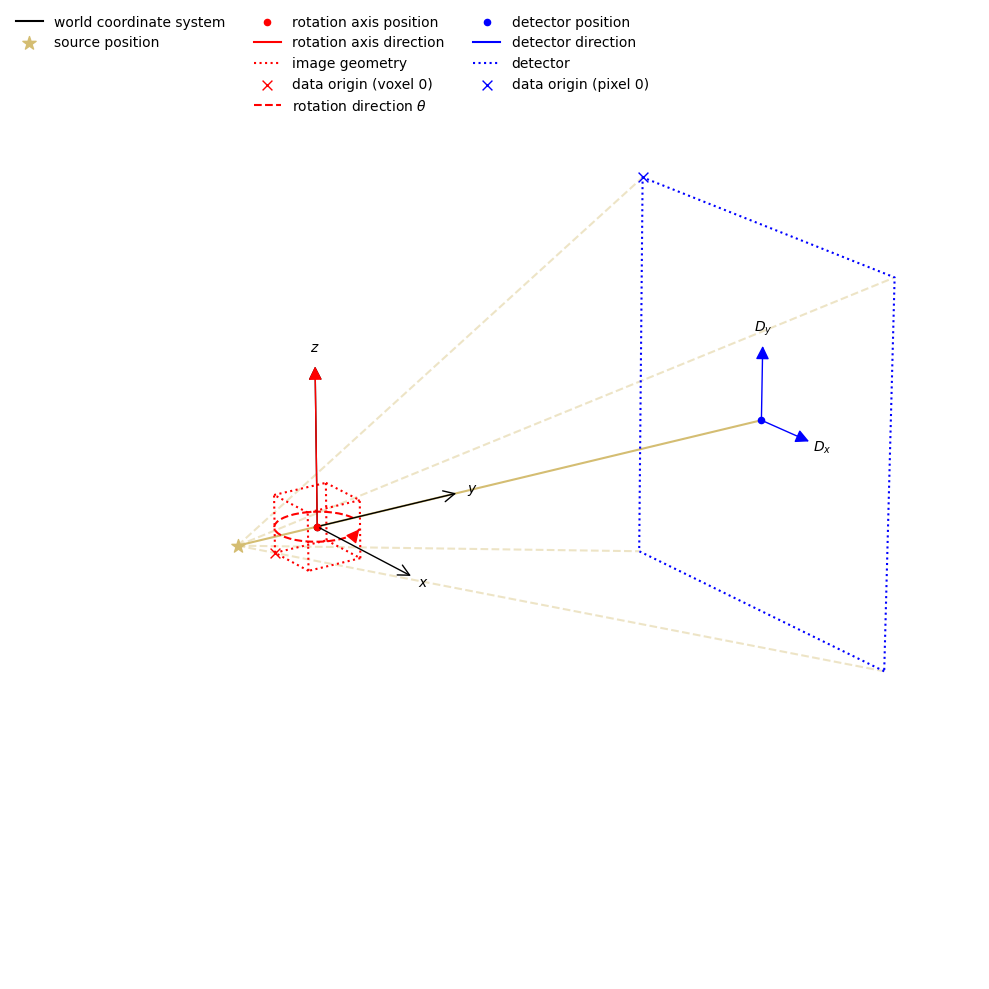

In [7]:
show_geometry(orbital_acq_geom)

In [8]:
print(orbital_acq_geom)

3D Cone-beam tomography
System configuration:
	Source position: [  0.       , -94.1910019,   0.       ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.       , 561.0729751,   0.       ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [957 957]
	Pixel size: [0.45 0.45]
	Pixel origin: top-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1600
	Angles 0-9 in degrees: [360.   , 359.775, 359.55 , 359.325, 359.1  , 358.875, 358.65 , 358.425,
 358.2  , 357.975]
	Angles 1590-1599 in degrees: [2.25 , 2.025, 1.8  , 1.575, 1.35 , 1.125, 0.9  , 0.675, 0.45 , 0.225]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


## Loading Projections

In [9]:
orbital_acq_data = reader.read()

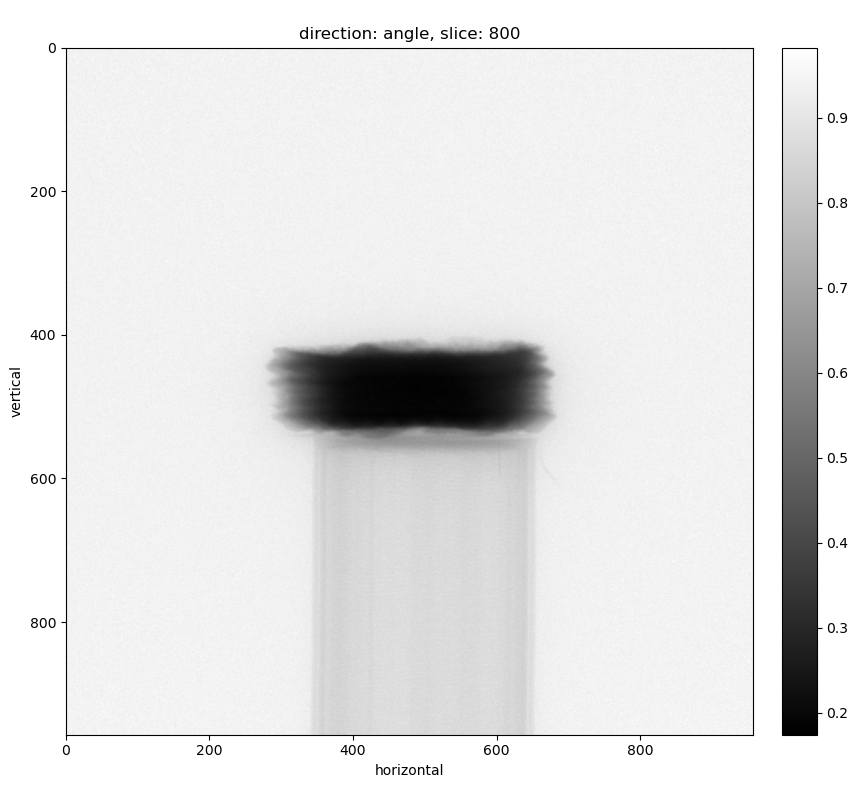

In [10]:
show2D(orbital_acq_data, origin='upper-left');

## Pre-processing and Reconstruction

In [11]:
orbital_data_exp = TransmissionAbsorptionConverter()(orbital_acq_data)

In [12]:
processor = CentreOfRotationCorrector.image_sharpness("centre", "tigre")
processor.set_input(orbital_data_exp)
orbital_data_centred = processor.get_output()

In [13]:
if "orbital_data_centred" in locals() or "orbital_data_centred" in globals():
    print("Use data that has been corrected for the centre of rotation")
    data_corr = orbital_data_centred
else:
    print("Use data that has NOT been corrected for the centre of rotation")
    data_corr = orbital_data_exp

Use data that has NOT been corrected for the centre of rotation


In [14]:
orbital_image_geometry = data_corr.geometry.get_ImageGeometry()

if number_of_slices_to_reconstruct > 0:
    orbital_image_geometry.voxel_num_z = number_of_slices_to_reconstruct // scaling_factor

orbital_image_geometry.voxel_size_x = min(orbital_image_geometry.voxel_size_x, orbital_image_geometry.voxel_size_y, orbital_image_geometry.voxel_size_z)
orbital_image_geometry.voxel_size_y = orbital_image_geometry.voxel_size_x
orbital_image_geometry.voxel_size_z = orbital_image_geometry.voxel_size_x

In [15]:
orbital_recon = FDK(data_corr, orbital_image_geometry).run()

FDK recon

Input Data:
	angle: 1600
	vertical: 957
	horizontal: 957

Reconstruction Volume:
	vertical: 166
	horizontal_y: 957
	horizontal_x: 957

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



## Save the reconstruction as a stack of TIFF files

In [16]:
writer = TIFFWriter(orbital_recon, os.path.join(data_path, "orbital/slice"))
writer.write()

## Visualise the reconstruction

In [17]:
islicer(orbital_recon, origin='upper-left')

## Release memory

In [18]:
del data_corr
if "orbital_data_centred" in locals() or "orbital_data_centred" in globals():
    del orbital_data_centred
del orbital_data_exp
del orbital_acq_data
del reader

gc.collect();

# Using a per-projection geometry

## Loading Geometry

In [19]:
reader = RXSolutionsDataReader(CSV_file_path, 
                               roi=roi)

655.2640860630297 139.0581742770099


In [20]:
flexible_acq_geom = reader.get_geometry()

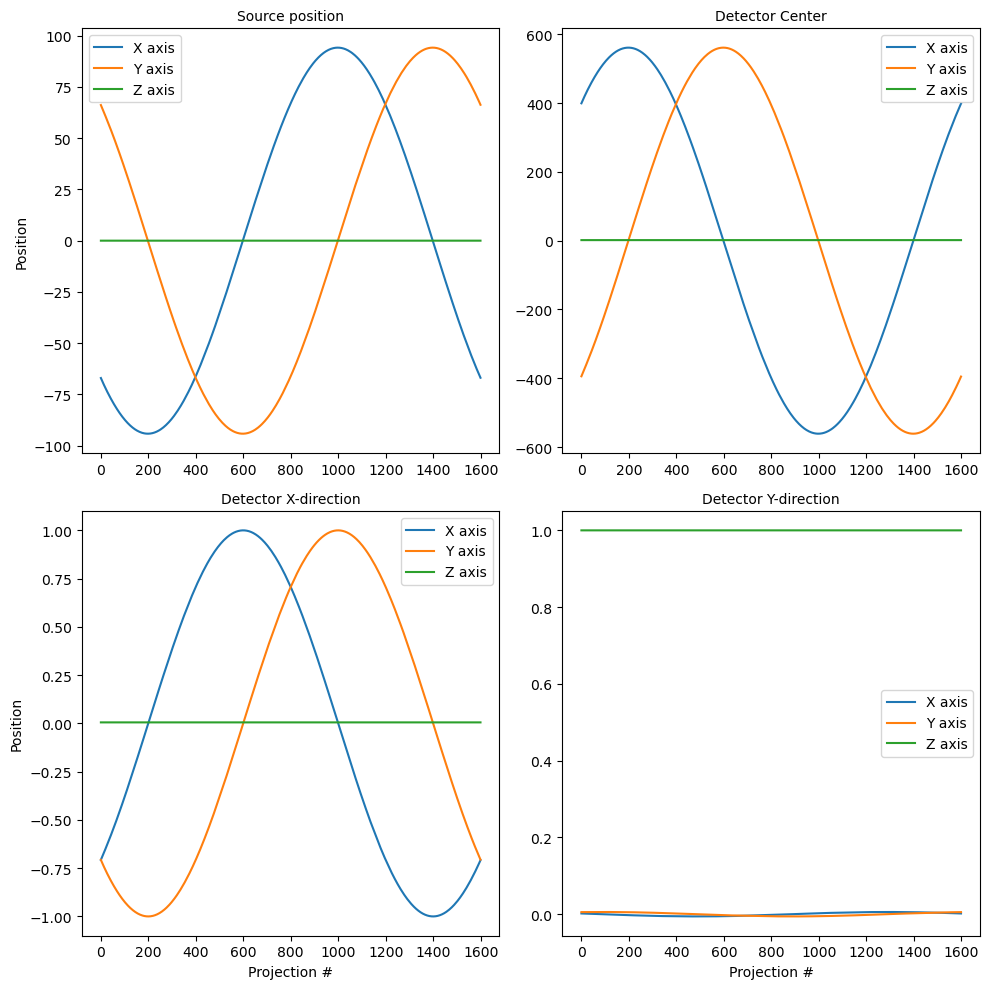

In [21]:
show_system_positions(flexible_acq_geom)

In [22]:
print(flexible_acq_geom)

Per-projection 3D Cone-beam tomography
System configuration:
	Number of projections: 1600
	Source positions 0-9: [[-6.70254000e+01, 6.61776000e+01, 2.84217094e-14],
 [-6.72940000e+01, 6.59045000e+01, 2.84217094e-14],
 [-6.75561000e+01, 6.56357000e+01, 2.84217094e-14],
 [-6.78223000e+01, 6.53607000e+01, 2.84217094e-14],
 [-6.80826000e+01, 6.50896000e+01, 2.84217094e-14],
 [-6.83462000e+01, 6.48126000e+01, 2.84217094e-14],
 [-6.86023000e+01, 6.45415000e+01, 2.84217094e-14],
 [-6.88638000e+01, 6.42625000e+01, 2.84217094e-14],
 [-6.91252000e+01, 6.39812000e+01, 2.84217094e-14],
 [-6.93795000e+01, 6.37054000e+01, 2.84217094e-14]]
	Detector positions 0-9: [[ 399.254,-394.204,   1.612],
 [ 400.854,-392.577,   1.612],
 [ 402.416,-390.976,   1.612],
 [ 404.001,-389.338,   1.612],
 [ 405.552,-387.723,   1.612],
 [ 407.122,-386.073,   1.612],
 [ 408.647,-384.458,   1.612],
 [ 410.205,-382.796,   1.612],
 [ 411.762,-381.121,   1.612],
 [ 413.277,-379.477,   1.612]]
	Detector directions x 0-9: [[-0

## Loading Projections

In [23]:
flexible_acq_data = reader.read()

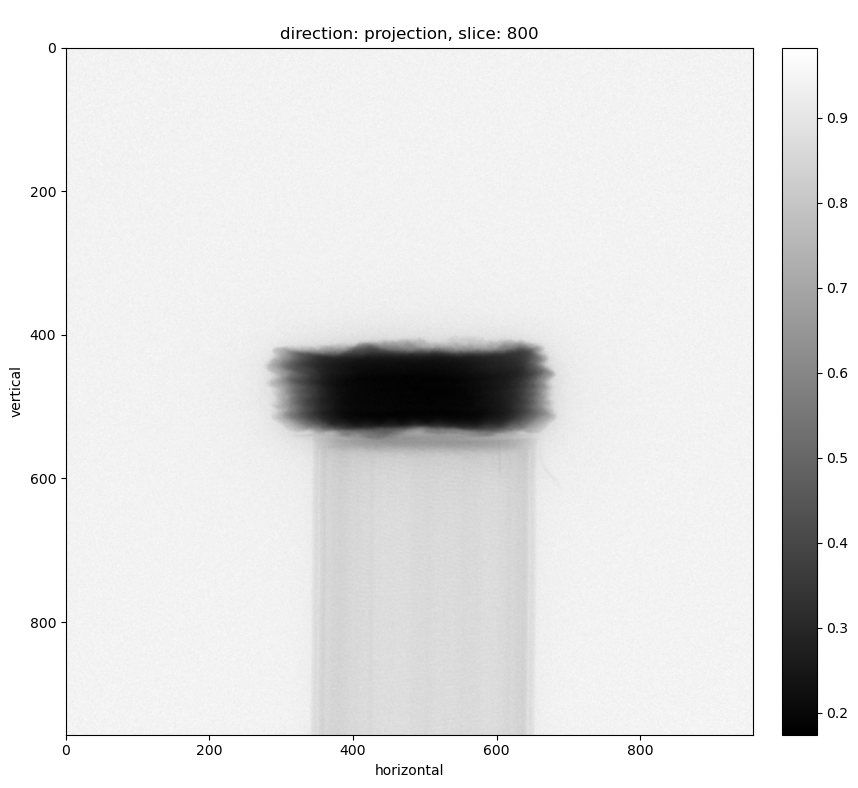

In [24]:
show2D(flexible_acq_data, origin='upper-left');

# Pre-processing and Reconstruction

In [25]:
# Prepare the data for Astra
flexible_acq_data.reorder(order='astra');

flexible_data_exp = TransmissionAbsorptionConverter()(flexible_acq_data)

In [26]:
# Use the system magnification to compute the voxel size
mag = flexible_data_exp.geometry.magnification
mean_mag = np.mean(mag)
print("Mean magnification: ", mean_mag)

voxel_size_xy = flexible_data_exp.geometry.config.panel.pixel_size[0] / mean_mag
voxel_size_z = flexible_data_exp.geometry.config.panel.pixel_size[1] / mean_mag

voxel_size_xy = min(voxel_size_xy, voxel_size_z)
voxel_size_z = voxel_size_xy

# Create an image geometry
num_voxel_xy = int(np.ceil(flexible_data_exp.geometry.config.panel.num_pixels[0]))
num_voxel_z = int(np.ceil(flexible_data_exp.geometry.config.panel.num_pixels[1]))

if number_of_slices_to_reconstruct > 0:
    num_voxel_z = number_of_slices_to_reconstruct // scaling_factor

image_geometry = ImageGeometry(num_voxel_xy, num_voxel_xy, num_voxel_z, voxel_size_xy, voxel_size_xy, voxel_size_z)

print(image_geometry)

Mean magnification:  6.956803489788658
Number of channels: 1
channel_spacing: 1.0
voxel_num : x957,y957,z166
voxel_size : x0.06468498987096678,y0.06468498987096678,z0.06468498987096678
center : x0,y0,z0



In [27]:
# Reconstruct using FDK
# Instantiate the reconstruction algorithm
fdk = FBP(image_geometry, flexible_data_exp.geometry)
fdk.set_input(flexible_data_exp)

# Perform the actual CT reconstruction
flexible_recon = fdk.get_output()

## Save the reconstruction as a stack of TIFF files

In [28]:
writer = TIFFWriter(flexible_recon, os.path.join(data_path, "flexible/slice"))
writer.write()

## Visualise the reconstruction

In [29]:
islicer(flexible_recon, origin='upper-left')

# Compare the two reconstructions

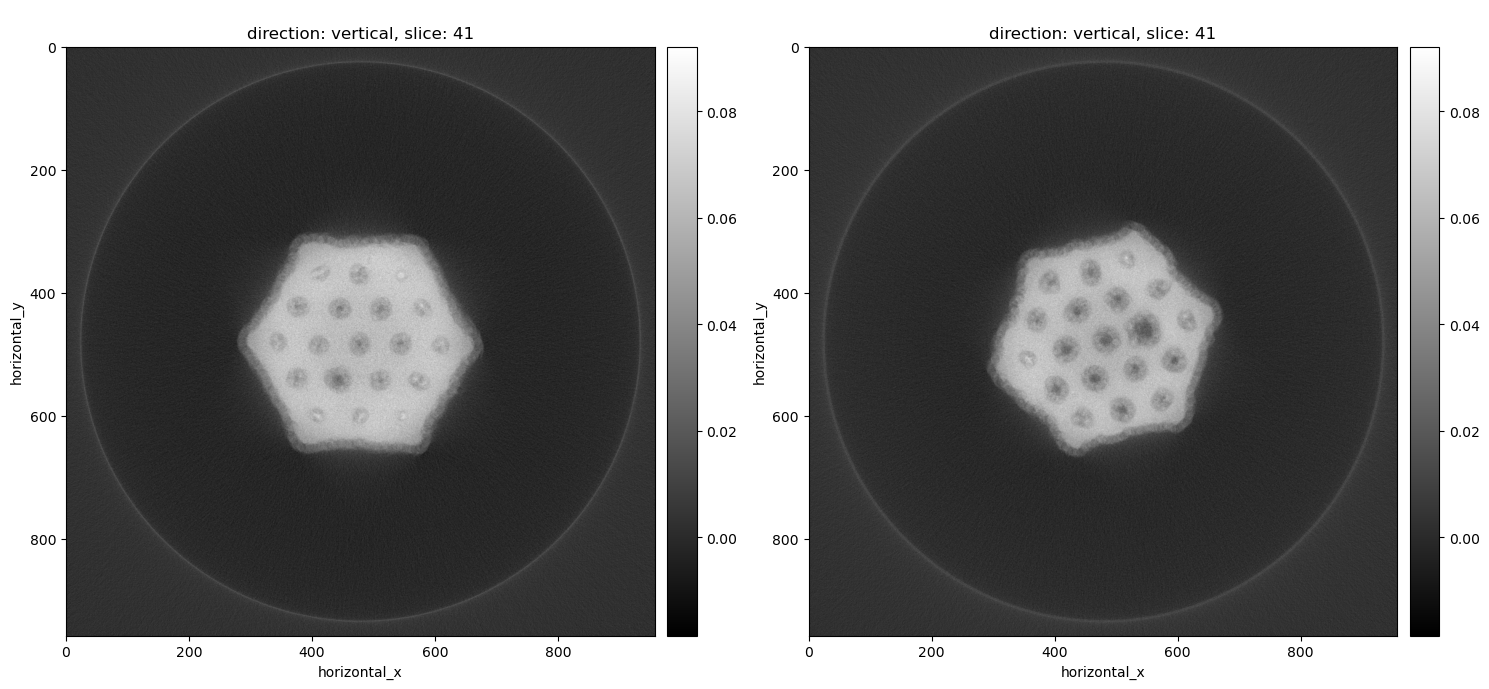

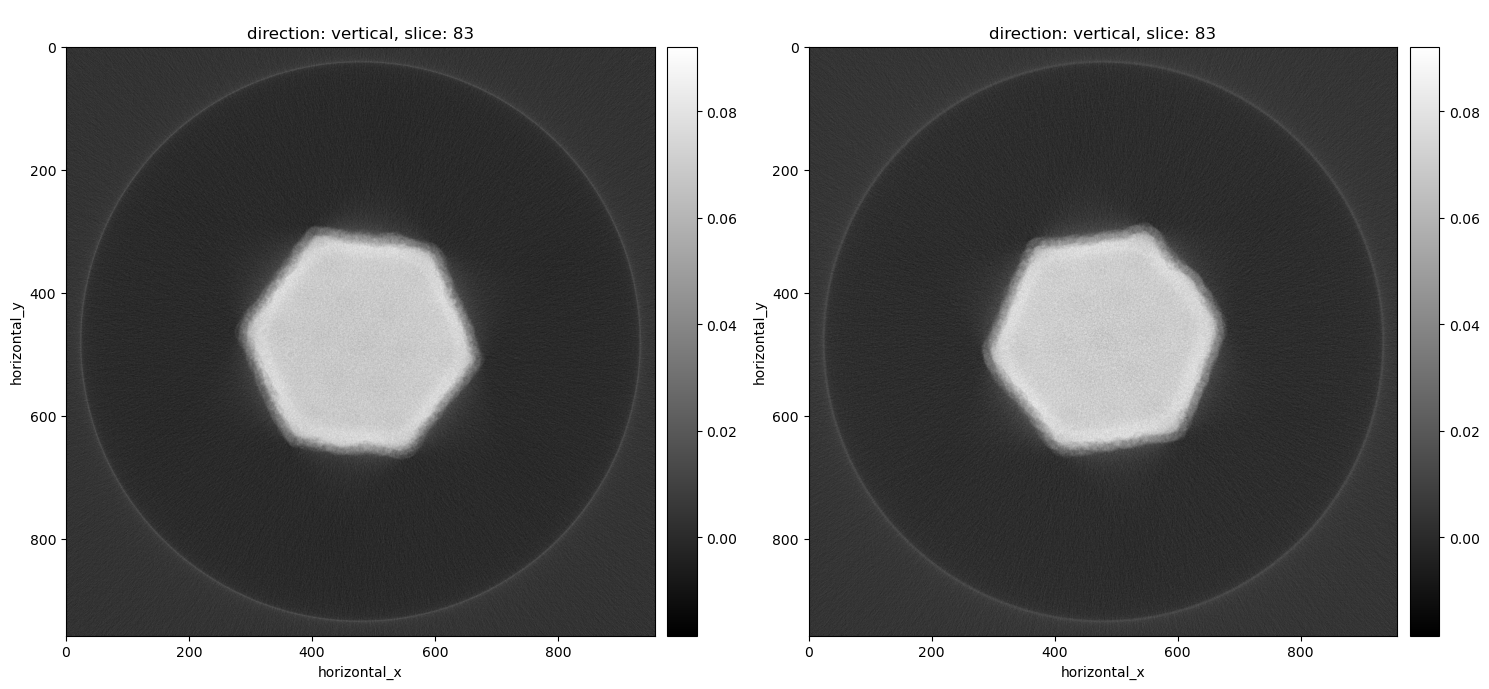

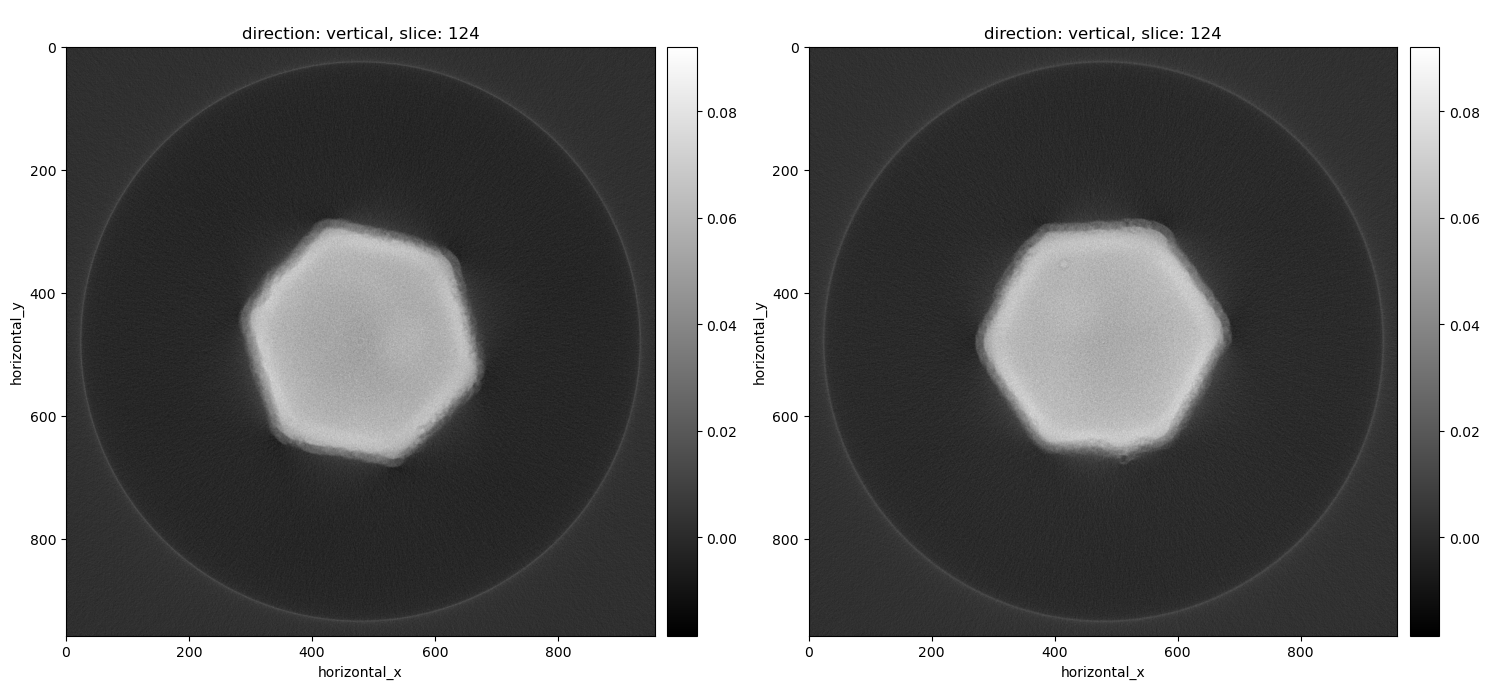

In [30]:
half_number_of_slices = orbital_recon.shape[0] // 2
fix_range = (min(orbital_recon.min(), flexible_recon.min()), max(orbital_recon.max(), flexible_recon.max()))

show2D([orbital_recon, flexible_recon], origin='upper-left', fix_range=fix_range, slice_list=(('vertical',half_number_of_slices // 2)))
show2D([orbital_recon, flexible_recon], origin='upper-left', fix_range=fix_range, slice_list=(('vertical',half_number_of_slices)))
show2D([orbital_recon, flexible_recon], origin='upper-left', fix_range=fix_range, slice_list=(('vertical',half_number_of_slices + half_number_of_slices // 2)))

In [31]:
link_islicer(islicer(orbital_recon, origin='upper-left'), islicer(flexible_recon, origin='upper-left'))